In [ ]:
%matplotlib inline

In [3]:
# pip install auto-sklearn


# Metrics

In *Auto-sklearn*, model is optimized over a metric, either built-in or
custom metric. Moreover, it is also possible to calculate multiple metrics
per run. The following examples show how to calculate metrics built-in
and self-defined metrics for a classification problem.


In [1]:
import autosklearn.classification
import numpy as np
import pandas as pd
import sklearn.datasets
import sklearn.metrics
from autosklearn.metrics import balanced_accuracy, precision, recall, f1


def error(solution, prediction):
    # custom function defining error
    return np.mean(solution != prediction)


def get_metric_result(cv_results):
    results = pd.DataFrame.from_dict(cv_results)
    results = results[results["status"] == "Success"]
    cols = ["rank_test_scores", "param_classifier:__choice__", "mean_test_score"]
    cols.extend([key for key in cv_results.keys() if key.startswith("metric_")])
    return results[cols]

## Data Loading



In [2]:
X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=1
)

In [5]:
X[5] , y[5]

(array([1.245e+01, 1.570e+01, 8.257e+01, 4.771e+02, 1.278e-01, 1.700e-01,
        1.578e-01, 8.089e-02, 2.087e-01, 7.613e-02, 3.345e-01, 8.902e-01,
        2.217e+00, 2.719e+01, 7.510e-03, 3.345e-02, 3.672e-02, 1.137e-02,
        2.165e-02, 5.082e-03, 1.547e+01, 2.375e+01, 1.034e+02, 7.416e+02,
        1.791e-01, 5.249e-01, 5.355e-01, 1.741e-01, 3.985e-01, 1.244e-01]), 0)

## Build and fit a classifier



In [6]:
error_rate = autosklearn.metrics.make_scorer(
    name="custom_error",
    score_func=error,
    optimum=0,
    greater_is_better=False,
    needs_proba=False,
    needs_threshold=False,
)
cls = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    scoring_functions=[balanced_accuracy, precision, recall, f1, error_rate],
)
cls.fit(X_train, y_train, X_test, y_test)

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      per_run_time_limit=30,
                      scoring_functions=[balanced_accuracy, precision, recall,
                                         f1, custom_error],
                      time_left_for_this_task=120)

## Get the Score of the final ensemble



In [7]:
predictions = cls.predict(X_test)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, predictions))

print("#" * 80)
print("Metric results")
print(get_metric_result(cls.cv_results_).to_string(index=False))

Accuracy score 0.951048951048951
################################################################################
Metric results
 rank_test_scores param_classifier:__choice__  mean_test_score  metric_balanced_accuracy  metric_precision  metric_recall  metric_f1  metric_custom_error
                6               random_forest         0.971631                  0.969533          0.977528       0.977528   0.977528             0.028369
                6                         mlp         0.971631                  0.961538          0.956989       1.000000   0.978022             0.028369
               26                         mlp         0.943262                  0.935069          0.945055       0.966292   0.955556             0.056738
               16               random_forest         0.964539                  0.959918          0.966667       0.977528   0.972067             0.035461
                6                         mlp         0.971631                  0.961538          0.9

In [13]:
res=get_metric_result(cls.cv_results_)

In [15]:
res.to_csv("res.csv", index=False)

In [16]:
%matplotlib inline


# Logging and debugging

This example shows how to provide a custom logging configuration to *auto-sklearn*.
We will be fitting 2 pipelines and showing any INFO-level msg on console.
Even if you do not provide a logging_configuration, autosklearn creates a log file
in the temporal working directory. This directory can be specified via the `tmp_folder`
as exemplified below.

This example also highlights additional information about *auto-sklearn* internal
directory structure.


In [20]:
import pathlib

import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection

import autosklearn.classification

## Data Loading
Load kr-vs-kp dataset from https://www.openml.org/d/3



In [17]:
X, y = data = sklearn.datasets.fetch_openml(data_id=3, return_X_y=True, as_frame=True)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=1
)

## Create a logging config
*auto-sklearn* uses a default
[logging config](https://github.com/automl/auto-sklearn/blob/master/autosklearn/util/logging.yaml)
We will instead create a custom one as follows:



In [18]:
logging_config = {
    "version": 1,
    "disable_existing_loggers": True,
    "formatters": {
        "custom": {
            # More format options are available in the official
            # `documentation <https://docs.python.org/3/howto/logging-cookbook.html>`_
            "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
        }
    },
    # Any INFO level msg will be printed to the console
    "handlers": {
        "console": {
            "level": "INFO",
            "formatter": "custom",
            "class": "logging.StreamHandler",
            "stream": "ext://sys.stdout",
        },
    },
    "loggers": {
        "": {  # root logger
            "level": "DEBUG",
        },
        "Client-EnsembleBuilder": {
            "level": "DEBUG",
            "handlers": ["console"],
        },
    },
}

In [28]:
%rm -rf tmp_folder


## Build and fit a classifier



In [29]:
cls = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=30,
    # Bellow two flags are provided to speed up calculations
    # Not recommended for a real implementation
    initial_configurations_via_metalearning=0,
    smac_scenario_args={"runcount_limit": 2},
    # Pass the config file we created
    logging_config=logging_config,
    # *auto-sklearn* generates temporal files under tmp_folder
    tmp_folder="./tmp_folder",
    # By default tmp_folder is deleted. We will preserve it
    # for debug purposes
    delete_tmp_folder_after_terminate=False,
)
cls.fit(X_train, y_train, X_test, y_test)

# *auto-sklearn* generates intermediate files which can be of interest
# Dask multiprocessing information. Useful on multi-core runs:
#   * tmp_folder/distributed.log
# The individual fitted estimators are written to disk on:
#   * tmp_folder/.auto-sklearn/runs
# SMAC output is stored in this directory.
# For more info, you can check the `SMAC documentation <https://github.com/automl/SMAC3>`_
#   * tmp_folder/smac3-output
# Auto-sklearn always outputs to this log file
# tmp_folder/AutoML*.log
for filename in pathlib.Path("./tmp_folder1").glob("*"):
    print(filename)

/usr/local/lib/python3.7/dist-packages/autosklearn/data/target_validator.py:188: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  "Fitting transformer with a pandas series which"


2022-10-30 23:53:36,587 - Client-EnsembleBuilder - WARNING - No runs were available to build an ensemble from


No runs were available to build an ensemble from


2022-10-30 23:53:36,595 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.52146
	Members: [0]
	Weights: [1.]
	Identifiers: (1, 1, 0.0)

2022-10-30 23:53:36,625 - Client-EnsembleBuilder - INFO - DummyFuture: ([{'Timestamp': Timestamp('2022-10-30 23:53:36.608024'), 'ensemble_optimization_score': 0.47853535353535354, 'ensemble_test_score': 0.47434292866082606}], 50)/SingleThreadedClient() Started Ensemble builder job at 2022.10.30-23.53.36 for iteration 0.
2022-10-30 23:53:40,115 - Client-EnsembleBuilder - INFO - Discarding 0/1 runs
2022-10-30 23:53:40,124 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.05934
	Members: [0]
	Weights: [1.]
	Identifiers: (1, 3, 0.0)

2022-10-30 23:53:40,152 - Client-EnsembleBuilder - INFO - DummyFuture: ([{'Timestamp': Timestamp('2022-10-30 23:53:40.128703'), 'ensemble_optimization_score': 0.9406565656565656, 'ensemble_test_score': 0.9411764705882353}], 50)/SingleThreadedClient() Started Ensemble builder job at 2

In [ ]:
%matplotlib inline


# Early stopping and Callbacks

The example below shows how we can use the ``get_trials_callback`` parameter of
auto-sklearn to implement an early-stopping mechanism through a callback.

These callbacks give access to the result of each model + hyperparameter configuration
optimized by SMAC, the underlying optimizer for autosklearn. By checking the cost of
a result, we can implement a simple yet effective early stopping mechanism!

Do note however, this does not provide any access to the ensembles that autosklearn
produces, only the individual models. You may wish to perform a more sophisticated
early stopping mechanism such that there are enough good models for autosklearn to build
and ensemble with. This is here to provide a simple example.


In [30]:
from __future__ import annotations

from pprint import pprint

import sklearn.datasets
import sklearn.metrics

import autosklearn.classification

from smac.optimizer.smbo import SMBO
from smac.runhistory.runhistory import RunInfo, RunValue

## Build and fit a classifier



In [31]:
def callback(
    smbo: SMBO,
    run_info: RunInfo,
    result: RunValue,
    time_left: float,
) -> bool | None:
    """Stop early if we get a very low cost value for a single run

    The return value indicates to SMAC whether to stop or not. False will
    stop the search process while any other value will mean it continues.
    """
    # You can find out the parameters in the SMAC documentation
    # https://automl.github.io/SMAC3/main/
    if result.cost <= 0.02:
        print("Stopping!")
        print(run_info)
        print(result)
        return False


X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=1
)

automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120, per_run_time_limit=30, get_trials_callback=callback
)
automl.fit(X_train, y_train, dataset_name="breast_cancer")

2022-10-30 23:53:57,876 - Client-EnsembleBuilder - INFO - Discarding 0/1 runs
2022-10-30 23:53:57,885 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.02837
	Members: [0]
	Weights: [1.]
	Identifiers: (1, 2, 0.0)

2022-10-30 23:53:57,905 - Client-EnsembleBuilder - INFO - DummyFuture: ([{'Timestamp': Timestamp('2022-10-30 23:53:57.890839'), 'ensemble_optimization_score': 0.9716312056737588}], 50)/SingleThreadedClient() Started Ensemble builder job at 2022.10.30-23.53.57 for iteration 0.
2022-10-30 23:53:59,340 - Client-EnsembleBuilder - INFO - Discarding 0/2 runs
2022-10-30 23:53:59,396 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.02837 1: 0.02128 2: 0.01418 3: 0.01418 4: 0.01418 5: 0.01418 6: 0.01418 7: 0.01418 8: 0.01418 9: 0.01418 10: 0.01418 11: 0.01418 12: 0.01418 13: 0.01418 14: 0.01418 15: 0.01418 16: 0.01418 17: 0.01418 18: 0.01418 19: 0.01418 20: 0.01418 21: 0.01418 22: 0.01418 23: 0.01418 24: 0.01418 25: 0.01418 26: 0.01418 27: 

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      get_trials_callback=<function callback at 0x7f0b5333ddd0>,
                      per_run_time_limit=30, time_left_for_this_task=120)

## View the models found by auto-sklearn



In [32]:
print(automl.leaderboard())

          rank  ensemble_weight           type      cost  duration
model_id                                                          
7            1             0.68    extra_trees  0.014184  1.892267
2            2             0.10  random_forest  0.028369  2.111099
3            3             0.22            mlp  0.028369  1.374038


## Print the final ensemble constructed by auto-sklearn



In [33]:
pprint(automl.show_models(), indent=4)

{   2: {   'balancing': Balancing(random_state=1),
           'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7f0b52cf2c10>,
           'cost': 0.028368794326241176,
           'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f0b52cf5d50>,
           'ensemble_weight': 0.1,
           'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f0b52cf24d0>,
           'model_id': 2,
           'rank': 1,
           'sklearn_classifier': RandomForestClassifier(max_features=5, n_estimators=512, n_jobs=1,
                       random_state=1, warm_start=True)},
    3: {   'balancing': Balancing(random_state=1),
           'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7f0b5731d4d0>,
           'cost': 0.028368794326241176,
           'data_preprocessor': <autosklearn.pipeline.components

## Get the Score of the final ensemble



In [34]:
predictions = automl.predict(X_test)
print("Accuracy score:", sklearn.metrics.accuracy_score(y_test, predictions))

Accuracy score: 0.9440559440559441


In [35]:
%matplotlib inline


# Feature Types

In *auto-sklearn* it is possible to specify the feature types of a dataset when calling
the method :meth:`fit() <autosklearn.classification.AutoSklearnClassifier.fit>` by
specifying the argument ``feat_type``.
The following example demonstrates a way it can be done.

Additionally, you can provide a properly formatted pandas DataFrame, and the feature
types will be automatically inferred, as demonstrated in
`sphx_glr_examples_40_advanced_example_pandas_train_test.py`.


In [36]:
import numpy as np

import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

import autosklearn.classification

## Data Loading
Load Australian dataset from https://www.openml.org/d/40981



In [37]:
bunch = data = sklearn.datasets.fetch_openml(data_id=40981, as_frame=True)
y = bunch["target"].to_numpy()
X = bunch["data"].to_numpy(np.float)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=1
)

# Auto-sklearn can automatically recognize categorical/numerical data from a pandas
# DataFrame. This example highlights how the user can provide the feature types,
# when using numpy arrays, as there is no per-column dtype in this case.
# feat_type is a list that tags each column from a DataFrame/ numpy array / list
# with the case-insensitive string categorical or numerical, accordingly.
feat_type = [
    "Categorical" if x.name == "category" else "Numerical" for x in bunch["data"].dtypes
]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


## Build and fit a classifier



In [38]:
cls = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=30,
    # Bellow two flags are provided to speed up calculations
    # Not recommended for a real implementation
    initial_configurations_via_metalearning=0,
    smac_scenario_args={"runcount_limit": 1},
)
cls.fit(X_train, y_train, X_test, y_test, feat_type=feat_type)

2022-10-30 23:55:35,479 - Client-EnsembleBuilder - INFO - Discarding 0/1 runs
2022-10-30 23:55:35,491 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.14035
	Members: [0]
	Weights: [1.]
	Identifiers: (1, 2, 0.0)

2022-10-30 23:55:35,511 - Client-EnsembleBuilder - INFO - DummyFuture: ([{'Timestamp': Timestamp('2022-10-30 23:55:35.495833'), 'ensemble_optimization_score': 0.8596491228070176, 'ensemble_test_score': 0.8786127167630058}], 50)/SingleThreadedClient() Started Ensemble builder job at 2022.10.30-23.55.35 for iteration 0.


AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      initial_configurations_via_metalearning=0,
                      per_run_time_limit=3,
                      smac_scenario_args={'runcount_limit': 1},
                      time_left_for_this_task=30)

## Get the Score of the final ensemble



In [39]:
predictions = cls.predict(X_test)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, predictions))

Accuracy score 0.8786127167630058


In [ ]:
%matplotlib inline


# Obtain run information

The following example shows how to obtain information from a finished
Auto-sklearn run. In particular, it shows:
* how to query which models were evaluated by Auto-sklearn
* how to query the models in the final ensemble
* how to get general statistics on the what Auto-sklearn evaluated

Auto-sklearn is a wrapper on top of
the sklearn models. This example illustrates how to interact
with the sklearn components directly, in this case a PCA preprocessor.


In [40]:
from pprint import pprint

import sklearn.datasets
import sklearn.metrics

import autosklearn.classification

## Data Loading



In [41]:
X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=1
)

## Build and fit the classifier



In [42]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=30,
    per_run_time_limit=10,
    disable_evaluator_output=False,
    # To simplify querying the models in the final ensemble, we
    # restrict auto-sklearn to use only pca as a preprocessor
    include={"feature_preprocessor": ["pca"]},
)
automl.fit(X_train, y_train, dataset_name="breast_cancer")

[WARNING] [2022-10-30 23:57:59,600:Client-AutoMLSMBO(1)::breast_cancer] Configuration 176 not found
[WARNING] [2022-10-30 23:57:59,600:Client-AutoMLSMBO(1)::breast_cancer] Configuration 601 not found
[WARNING] [2022-10-30 23:57:59,600:Client-AutoMLSMBO(1)::breast_cancer] Configuration 162 not found
[WARNING] [2022-10-30 23:57:59,600:Client-AutoMLSMBO(1)::breast_cancer] Configuration 476 not found
[WARNING] [2022-10-30 23:57:59,600:Client-AutoMLSMBO(1)::breast_cancer] Configuration 492 not found
[WARNING] [2022-10-30 23:57:59,600:Client-AutoMLSMBO(1)::breast_cancer] Configuration 440 not found
[WARNING] [2022-10-30 23:57:59,600:Client-AutoMLSMBO(1)::breast_cancer] Configuration 32 not found
[WARNING] [2022-10-30 23:57:59,600:Client-AutoMLSMBO(1)::breast_cancer] Configuration 220 not found
[WARNING] [2022-10-30 23:57:59,601:Client-AutoMLSMBO(1)::breast_cancer] Configuration 566 not found
[WARNING] [2022-10-30 23:57:59,601:Client-AutoMLSMBO(1)::breast_cancer] Configuration 332 not found
[

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      include={'feature_preprocessor': ['pca']},
                      per_run_time_limit=10, time_left_for_this_task=30)

## Predict using the model



In [43]:
predictions = automl.predict(X_test)
print("Accuracy score:{}".format(sklearn.metrics.accuracy_score(y_test, predictions)))

Accuracy score:0.958041958041958


## Report the models found by Auto-Sklearn

Auto-sklearn uses
[Ensemble Selection](https://www.cs.cornell.edu/~alexn/papers/shotgun.icml04.revised.rev2.pdf)
to construct ensembles in a post-hoc fashion. The ensemble is a linear
weighting of all models constructed during the hyperparameter optimization.
This prints the final ensemble. It is a dictionary where ``model_id`` of
each model is a key, and value is a dictionary containing information
of that model. A model's dict contains its ``'model_id'``, ``'rank'``,
``'cost'``, ``'ensemble_weight'``, and the model itself. The model is
given by the ``'data_preprocessor'``, ``'feature_preprocessor'``,
``'regressor'/'classifier'`` and ``'sklearn_regressor'/'sklearn_classifier'``
entries. But for the ``'cv'`` resampling strategy, the same for each cv
model is stored in the ``'estimators'`` list in the dict, along with the
``'voting_model'``.



In [44]:
pprint(automl.show_models(), indent=4)

{   2: {   'balancing': Balancing(random_state=1),
           'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7f0b53311490>,
           'cost': 0.07801418439716312,
           'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f0b57692710>,
           'ensemble_weight': 0.12,
           'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f0b58389a10>,
           'model_id': 2,
           'rank': 1,
           'sklearn_classifier': RandomForestClassifier(max_features=5, n_estimators=512, n_jobs=1,
                       random_state=1, warm_start=True)},
    3: {   'balancing': Balancing(random_state=1),
           'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7f0b52afca50>,
           'cost': 0.07092198581560283,
           'data_preprocessor': <autosklearn.pipeline.components.

## Report statistics about the search

Print statistics about the auto-sklearn run such as number of
iterations, number of models failed with a time out etc.



In [45]:
print(automl.sprint_statistics())

auto-sklearn results:
  Dataset name: breast_cancer
  Metric: accuracy
  Best validation score: 0.971631
  Number of target algorithm runs: 8
  Number of successful target algorithm runs: 8
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 0
  Number of target algorithms that exceeded the memory limit: 0



## Detailed statistics about the search - part 1

Auto-sklearn also keeps detailed statistics of the hyperparameter
optimization procedurce, which are stored in a so-called
[run history](https://automl.github.io/SMAC3/main/api/smac.runhistory.runhistory.html#smac.runhistory.runhistory.RunHistory).



In [46]:
print(automl.automl_.runhistory_)

Runs are stored inside an ``OrderedDict`` called ``data``:



In [47]:
print(len(automl.automl_.runhistory_.data))

9


Let's iterative over all entries



In [48]:
for run_key in automl.automl_.runhistory_.data:
    print("#########")
    print(run_key)
    print(automl.automl_.runhistory_.data[run_key])

#########
RunKey(config_id=1, instance_id='{"task_id": "breast_cancer"}', seed=0, budget=0.0)
RunValue(cost=0.07801418439716312, time=2.77616810798645, status=<StatusType.SUCCESS: 1>, starttime=1667174279.8697643, endtime=1667174282.6768606, additional_info={'duration': 2.511806011199951, 'num_run': 2, 'train_loss': 0.0, 'configuration_origin': 'Initial design'})
#########
RunKey(config_id=2, instance_id='{"task_id": "breast_cancer"}', seed=0, budget=0.0)
RunValue(cost=0.07092198581560283, time=1.8057336807250977, status=<StatusType.SUCCESS: 1>, starttime=1667174282.755526, endtime=1667174284.5809262, additional_info={'duration': 1.7015302181243896, 'num_run': 3, 'train_loss': 0.06315789473684208, 'configuration_origin': 'Initial design'})
#########
RunKey(config_id=3, instance_id='{"task_id": "breast_cancer"}', seed=0, budget=0.0)
RunValue(cost=0.028368794326241176, time=2.095503568649292, status=<StatusType.SUCCESS: 1>, starttime=1667174284.6991987, endtime=1667174286.814486, additio

and have a detailed look at one entry:



In [49]:
run_key = list(automl.automl_.runhistory_.data.keys())[0]
run_value = automl.automl_.runhistory_.data[run_key]

The ``run_key`` contains all information describing a run:



In [50]:
print("Configuration ID:", run_key.config_id)
print("Instance:", run_key.instance_id)
print("Seed:", run_key.seed)
print("Budget:", run_key.budget)

Configuration ID: 1
Instance: {"task_id": "breast_cancer"}
Seed: 0
Budget: 0.0


and the configuration can be looked up in the run history as well:



In [51]:
print(automl.automl_.runhistory_.ids_config[run_key.config_id])

Configuration(values={
  'balancing:strategy': 'none',
  'classifier:__choice__': 'random_forest',
  'classifier:random_forest:bootstrap': 'True',
  'classifier:random_forest:criterion': 'gini',
  'classifier:random_forest:max_depth': 'None',
  'classifier:random_forest:max_features': 0.5,
  'classifier:random_forest:max_leaf_nodes': 'None',
  'classifier:random_forest:min_impurity_decrease': 0.0,
  'classifier:random_forest:min_samples_leaf': 1,
  'classifier:random_forest:min_samples_split': 2,
  'classifier:random_forest:min_weight_fraction_leaf': 0.0,
  'data_preprocessor:__choice__': 'feature_type',
  'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'mean',
  'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'standardize',
  'feature_preprocessor:__choice__': 'pca',
  'feature_preprocessor:pca:keep_variance': 0.9999,
  'feature_preprocessor:pca:whiten': 'False',
})



The only other important entry is the budget in case you are using
auto-sklearn with
`sphx_glr_examples_60_search_example_successive_halving.py`.
The remaining parts of the key can be ignored for auto-sklearn and are
only there because the underlying optimizer, SMAC, can handle more general
problems, too.



The ``run_value`` contains all output from running the configuration:



In [52]:
print("Cost:", run_value.cost)
print("Time:", run_value.time)
print("Status:", run_value.status)
print("Additional information:", run_value.additional_info)
print("Start time:", run_value.starttime)
print("End time", run_value.endtime)

Cost: 0.07801418439716312
Time: 2.77616810798645
Status: StatusType.SUCCESS
Additional information: {'duration': 2.511806011199951, 'num_run': 2, 'train_loss': 0.0, 'configuration_origin': 'Initial design'}
Start time: 1667174279.8697643
End time 1667174282.6768606


Cost is basically the same as a loss. In case the metric to optimize for
should be maximized, it is internally transformed into a minimization
metric. Additionally, the status type gives information on whether the run
was successful, while the additional information's most interesting entry
is the internal training loss. Furthermore, there is detailed information
on the runtime available.



As an example, let's find the best configuration evaluated. As
Auto-sklearn solves a minimization problem internally, we need to look
for the entry with the lowest loss:



In [53]:
losses_and_configurations = [
    (run_value.cost, run_key.config_id)
    for run_key, run_value in automl.automl_.runhistory_.data.items()
]
losses_and_configurations.sort()
print("Lowest loss:", losses_and_configurations[0][0])
print(
    "Best configuration:",
    automl.automl_.runhistory_.ids_config[losses_and_configurations[0][1]],
)

Lowest loss: 0.028368794326241176
Best configuration: Configuration(values={
  'balancing:strategy': 'weighting',
  'classifier:__choice__': 'mlp',
  'classifier:mlp:activation': 'tanh',
  'classifier:mlp:alpha': 1.103855734598575e-05,
  'classifier:mlp:batch_size': 'auto',
  'classifier:mlp:beta_1': 0.9,
  'classifier:mlp:beta_2': 0.999,
  'classifier:mlp:early_stopping': 'valid',
  'classifier:mlp:epsilon': 1e-08,
  'classifier:mlp:hidden_layer_depth': 3,
  'classifier:mlp:learning_rate_init': 0.00014375616988222174,
  'classifier:mlp:n_iter_no_change': 32,
  'classifier:mlp:num_nodes_per_layer': 229,
  'classifier:mlp:shuffle': 'True',
  'classifier:mlp:solver': 'adam',
  'classifier:mlp:tol': 0.0001,
  'classifier:mlp:validation_fraction': 0.1,
  'data_preprocessor:__choice__': 'feature_type',
  'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'most_frequent',
  'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'quantile_transfo

## Detailed statistics about the search - part 2

To maintain compatibility with scikit-learn, Auto-sklearn gives the
same data as
[cv_results_](https://scikit-learn.org/stable/modules/generated/sklearn.
model_selection.GridSearchCV.html).



In [54]:
print(automl.cv_results_)

{'mean_test_score': array([0.92198582, 0.92907801, 0.97163121, 0.89361702, 0.88652482,
       0.89361702, 0.97163121, 0.91489362]), 'rank_test_scores': array([4, 3, 1, 6, 8, 6, 1, 5]), 'mean_fit_time': array([2.77616811, 1.80573368, 2.09550357, 0.91585135, 0.78050256,
       0.95599556, 0.87216878, 0.97395015]), 'params': [{'balancing:strategy': 'none', 'classifier:__choice__': 'random_forest', 'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'pca', 'classifier:random_forest:bootstrap': 'True', 'classifier:random_forest:criterion': 'gini', 'classifier:random_forest:max_depth': 'None', 'classifier:random_forest:max_features': 0.5, 'classifier:random_forest:max_leaf_nodes': 'None', 'classifier:random_forest:min_impurity_decrease': 0.0, 'classifier:random_forest:min_samples_leaf': 1, 'classifier:random_forest:min_samples_split': 2, 'classifier:random_forest:min_weight_fraction_leaf': 0.0, 'data_preprocessor:feature_type:numerical_transformer:imputation:st

## Inspect the components of the best model

Iterate over the components of the model and print
The explained variance ratio per stage



In [55]:
for i, (weight, pipeline) in enumerate(automl.get_models_with_weights()):
    for stage_name, component in pipeline.named_steps.items():
        if "feature_preprocessor" in stage_name:
            print(
                "The {}th pipeline has a explained variance of {}".format(
                    i,
                    # The component is an instance of AutoSklearnChoice.
                    # Access the sklearn object via the choice attribute
                    # We want the explained variance attributed of
                    # each principal component
                    component.choice.preprocessor.explained_variance_ratio_,
                )
            )

The 0th pipeline has a explained variance of [0.46038401 0.16124884 0.09747816 0.06923404 0.06142479 0.03312917
 0.03182802 0.01555463 0.01348582 0.00965531 0.00870982 0.007397
 0.00547082 0.00443245 0.00396559 0.00313575 0.0022883  0.00195796
 0.00156348]
The 1th pipeline has a explained variance of [0.98080571 0.01684553]
The 2th pipeline has a explained variance of [4.32956881e-01 1.79057296e-01 1.11737571e-01 6.80724345e-02
 5.94611519e-02 3.70629898e-02 2.38430977e-02 1.49326086e-02
 1.37641366e-02 1.13704890e-02 1.03737258e-02 8.74116751e-03
 7.57629717e-03 4.86528503e-03 3.32225143e-03 2.55773043e-03
 2.20759805e-03 1.88675402e-03 1.36245140e-03 1.03409213e-03
 8.39749085e-04 7.91287172e-04 6.75655689e-04 5.42961621e-04
 5.02641737e-04 2.07827509e-04 1.74597367e-04]
The 3th pipeline has a explained variance of [0.76699224 0.17152095]
The 4th pipeline has a explained variance of [0.49503611 0.16649281 0.09111888 0.07213284 0.04865917 0.03208923
 0.01851537 0.01223987]
The 5th pip

In [56]:
%matplotlib inline


# Model Explanation

The following example shows how to fit a simple classification model with
*auto-sklearn* and use the [inspect module](https://scikit-learn.org/stable/inspection.html) from
scikit-learn to understand what affects the predictions.


In [57]:
import sklearn.datasets
from sklearn.inspection import plot_partial_dependence, permutation_importance
import matplotlib.pyplot as plt
import autosklearn.classification

## Load Data and Build a Model

We start by loading the "Run or walk" dataset from OpenML and train an auto-sklearn model on it.
For this dataset, the goal is to predict whether a person is running or walking based on
accelerometer and gyroscope data collected by a phone. For more information see
[here](https://www.openml.org/d/40922).



In [58]:
dataset = sklearn.datasets.fetch_openml(data_id=40922)

# Note: To speed up the example, we subsample the dataset
dataset.data = dataset.data.sample(n=5000, random_state=1, axis="index")
dataset.target = dataset.target[dataset.data.index]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    dataset.data, dataset.target, test_size=0.3, random_state=1
)

automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    tmp_folder="/tmp/autosklearn_inspect_predictions_example_tmp",
)
automl.fit(X_train, y_train, dataset_name="Run_or_walk_information")

s = automl.score(X_train, y_train)
print(f"Train score {s}")
s = automl.score(X_test, y_test)
print(f"Test score {s}")

/usr/local/lib/python3.7/dist-packages/autosklearn/data/target_validator.py:188: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  "Fitting transformer with a pandas series which"


[WARNING] [2022-10-31 00:02:21,810:Client-AutoMLSMBO(1)::Run_or_walk_information] Dataset run_or_walk_information already in meta-data. Removing occurence.
2022-10-31 00:02:26,232 - Client-EnsembleBuilder - INFO - Discarding 0/1 runs
2022-10-31 00:02:26,242 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.02338
	Members: [0]
	Weights: [1.]
	Identifiers: (1, 2, 0.0)

2022-10-31 00:02:26,263 - Client-EnsembleBuilder - INFO - DummyFuture: ([{'Timestamp': Timestamp('2022-10-31 00:02:26.248421'), 'ensemble_optimization_score': 0.9766233766233766}], 50)/SingleThreadedClient() Started Ensemble builder job at 2022.10.31-00.02.26 for iteration 0.
2022-10-31 00:02:42,449 - Client-EnsembleBuilder - INFO - Discarding 0/2 runs
2022-10-31 00:02:42,541 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.02338 1: 0.02338 2: 0.02251 3: 0.02251 4: 0.02251 5: 0.02251 6: 0.02165 7: 0.02251 8: 0.02251 9: 0.02165 10: 0.02251 11: 0.02251 12: 0.02251 13: 0.02251 14: 

## Compute permutation importance - part 1

Since auto-sklearn implements the scikit-learn interface, it can be used with the scikit-learn's
inspection module. So, now we first look at the [permutation importance](https://christophm.github.io/interpretable-ml-book/feature-importance.html), which defines the
decrease in a model score when a given feature is randomly permuted. So, the higher the score,
the more does the model's predictions depend on this feature.

**Note:** There are some pitfalls in interpreting these numbers, which can be found
in the [scikit-learn docs](https://scikit-learn.org/stable/modules/permutation_importance.html).



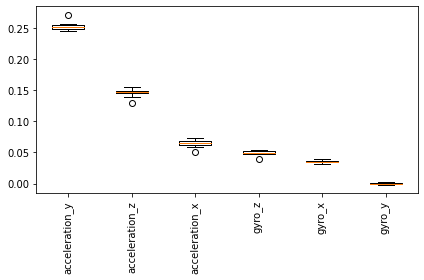

gyro_y    : 0.000 +/- 0.001
gyro_x    : 0.035 +/- 0.003
gyro_z    : 0.049 +/- 0.004
acceleration_x: 0.064 +/- 0.006
acceleration_z: 0.145 +/- 0.007
acceleration_y: 0.253 +/- 0.007


In [59]:
r = permutation_importance(automl, X_test, y_test, n_repeats=10, random_state=0)
sort_idx = r.importances_mean.argsort()[::-1]

plt.boxplot(
    r.importances[sort_idx].T, labels=[dataset.feature_names[i] for i in sort_idx]
)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

for i in sort_idx[::-1]:
    print(
        f"{dataset.feature_names[i]:10s}: {r.importances_mean[i]:.3f} +/- "
        f"{r.importances_std[i]:.3f}"
    )

## Create partial dependence (PD) and individual conditional expectation (ICE) plots - part 2

[ICE plots](https://christophm.github.io/interpretable-ml-book/ice.html) describe the relation
between feature values and the response value for each sample
individually -- it shows how the response value changes if the value of one feature is changed.

[PD plots](https://christophm.github.io/interpretable-ml-book/pdp.html) describe the relation
between feature values and the response value, i.e. the expected
response value wrt. one or multiple input features. Since we use a classification dataset, this
corresponds to the predicted class probability.

Since ``acceleration_y`` and ``acceleration_z`` turned out to have the largest impact on the response
value according to the permutation dependence, we'll first look at them and generate a plot
combining ICE (thin lines) and PD (thick line)



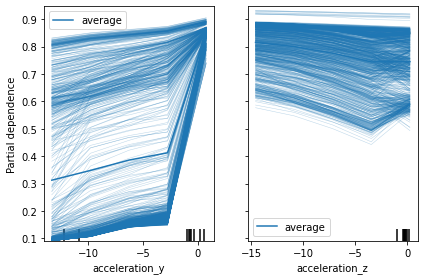

In [60]:
features = [1, 2]
plot_partial_dependence(
    automl,
    dataset.data,
    features=features,
    grid_resolution=5,
    kind="both",
    feature_names=dataset.feature_names,
)
plt.tight_layout()
plt.show()

## Create partial dependence (PDP) plots for more than one feature - part 3

A PD plot can also be generated for two features and thus allow to inspect the interaction between
these features. Again, we'll look at acceleration_y and acceleration_z.



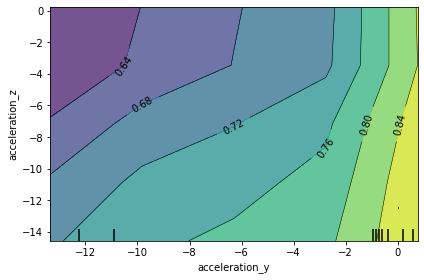

In [61]:
features = [[1, 2]]
plot_partial_dependence(
    automl,
    dataset.data,
    features=features,
    grid_resolution=5,
    feature_names=dataset.feature_names,
)
plt.tight_layout()
plt.show()

In [ ]:
%matplotlib inline


# Interpretable models

The following example shows how to inspect the models which *auto-sklearn*
optimizes over and how to restrict them to an interpretable subset.


In [62]:
from pprint import pprint

import autosklearn.classification
import sklearn.datasets
import sklearn.metrics

## Show available classification models

We will first list all classifiers Auto-sklearn chooses from. A similar
call is available for preprocessors (see below) and regression (not shown)
as well.



In [63]:
from autosklearn.pipeline.components.classification import ClassifierChoice

for name in ClassifierChoice.get_components():
    print(name)

adaboost
bernoulli_nb
decision_tree
extra_trees
gaussian_nb
gradient_boosting
k_nearest_neighbors
lda
liblinear_svc
libsvm_svc
mlp
multinomial_nb
passive_aggressive
qda
random_forest
sgd


## Show available preprocessors



In [64]:
from autosklearn.pipeline.components.feature_preprocessing import (
    FeaturePreprocessorChoice,
)

for name in FeaturePreprocessorChoice.get_components():
    print(name)

densifier
extra_trees_preproc_for_classification
extra_trees_preproc_for_regression
fast_ica
feature_agglomeration
kernel_pca
kitchen_sinks
liblinear_svc_preprocessor
no_preprocessing
nystroem_sampler
pca
polynomial
random_trees_embedding
select_percentile_classification
select_percentile_regression
select_rates_classification
select_rates_regression
truncatedSVD


## Data Loading



In [65]:
X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=1
)

## Build and fit a classifier

We will now only use a subset of the given classifiers and preprocessors.
Furthermore, we will restrict the ensemble size to ``1`` to only use the
single best model in the end. However, we would like to note that the
choice of which models is deemed interpretable is very much up to the user
and can change from use case to use case.



In [66]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    tmp_folder="/tmp/autosklearn_interpretable_models_example_tmp",
    include={
        "classifier": ["decision_tree", "lda", "sgd"],
        "feature_preprocessor": [
            "no_preprocessing",
            "polynomial",
            "select_percentile_classification",
        ],
    },
    ensemble_kwargs={"ensemble_size": 1},
)
automl.fit(X_train, y_train, dataset_name="breast_cancer")

[WARNING] [2022-10-31 00:08:10,294:Client-AutoMLSMBO(1)::breast_cancer] Configuration 176 not found
[WARNING] [2022-10-31 00:08:10,294:Client-AutoMLSMBO(1)::breast_cancer] Configuration 162 not found
[WARNING] [2022-10-31 00:08:10,294:Client-AutoMLSMBO(1)::breast_cancer] Configuration 476 not found
[WARNING] [2022-10-31 00:08:10,294:Client-AutoMLSMBO(1)::breast_cancer] Configuration 601 not found
[WARNING] [2022-10-31 00:08:10,294:Client-AutoMLSMBO(1)::breast_cancer] Configuration 492 not found
[WARNING] [2022-10-31 00:08:10,294:Client-AutoMLSMBO(1)::breast_cancer] Configuration 440 not found
[WARNING] [2022-10-31 00:08:10,294:Client-AutoMLSMBO(1)::breast_cancer] Configuration 32 not found
[WARNING] [2022-10-31 00:08:10,294:Client-AutoMLSMBO(1)::breast_cancer] Configuration 220 not found
[WARNING] [2022-10-31 00:08:10,294:Client-AutoMLSMBO(1)::breast_cancer] Configuration 566 not found
[WARNING] [2022-10-31 00:08:10,294:Client-AutoMLSMBO(1)::breast_cancer] Configuration 332 not found
[

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      ensemble_kwargs={'ensemble_size': 1},
                      include={'classifier': ['decision_tree', 'lda', 'sgd'],
                               'feature_preprocessor': ['no_preprocessing',
                                                        'polynomial',
                                                        'select_percentile_classification']},
                      per_run_time_limit=30, time_left_for_this_task=120,
                      tmp_folder='/tmp/autosklearn_interpretable_models_example_tmp')

## Print the final ensemble constructed by auto-sklearn



In [67]:
pprint(automl.show_models(), indent=4)

{   28: {   'balancing': Balancing(random_state=1, strategy='weighting'),
            'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7f0b52af08d0>,
            'cost': 0.007092198581560294,
            'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f0b51bb2690>,
            'ensemble_weight': 1.0,
            'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f0b52c3c6d0>,
            'model_id': 28,
            'rank': 1,
            'sklearn_classifier': SGDClassifier(alpha=0.0003272354910051561, average=True,
              eta0=2.9976399065090562e-05, l1_ratio=0.14999999999999974,
              learning_rate='invscaling', loss='squared_hinge', max_iter=1024,
              penalty='elasticnet', power_t=0.5037491320052959, random_state=1,
              tol=2.59922433981394e-05, warm_start=True)}}


## Get the Score of the final ensemble



In [68]:
predictions = automl.predict(X_test)
print("Accuracy score:", sklearn.metrics.accuracy_score(y_test, predictions))

Accuracy score: 0.9440559440559441


In [ ]:
%matplotlib inline


# Metrics

*Auto-sklearn* supports various built-in metrics, which can be found in the
`metrics section in the API <api:Built-in Metrics>`. However, it is also
possible to define your own metric and use it to fit and evaluate your model.
The following examples show how to use built-in and self-defined metrics for a
classification problem.


In [69]:
import numpy as np

import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

import autosklearn.classification
import autosklearn.metrics

## Custom Metrics



In [70]:
def accuracy(solution, prediction):
    # custom function defining accuracy
    return np.mean(solution == prediction)


def error(solution, prediction):
    # custom function defining error
    return np.mean(solution != prediction)


def accuracy_wk(solution, prediction, extra_argument):
    # custom function defining accuracy and accepting an additional argument
    assert extra_argument is None
    return np.mean(solution == prediction)


def error_wk(solution, prediction, extra_argument):
    # custom function defining error and accepting an additional argument
    assert extra_argument is None
    return np.mean(solution != prediction)


def metric_which_needs_x(solution, prediction, X_data, consider_col, val_threshold):
    # custom function defining accuracy
    assert X_data is not None
    rel_idx = X_data[:, consider_col] > val_threshold
    return np.mean(solution[rel_idx] == prediction[rel_idx])

## Data Loading



In [71]:
X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=1
)

## Print a list of available metrics



In [72]:
print("Available CLASSIFICATION metrics autosklearn.metrics.*:")
print("\t*" + "\n\t*".join(autosklearn.metrics.CLASSIFICATION_METRICS))

print("Available REGRESSION autosklearn.metrics.*:")
print("\t*" + "\n\t*".join(autosklearn.metrics.REGRESSION_METRICS))

Available CLASSIFICATION metrics autosklearn.metrics.*:
	*accuracy
	*balanced_accuracy
	*roc_auc
	*average_precision
	*log_loss
	*precision_macro
	*precision_micro
	*precision_samples
	*precision_weighted
	*recall_macro
	*recall_micro
	*recall_samples
	*recall_weighted
	*f1_macro
	*f1_micro
	*f1_samples
	*f1_weighted
Available REGRESSION autosklearn.metrics.*:
	*mean_absolute_error
	*mean_squared_error
	*root_mean_squared_error
	*mean_squared_log_error
	*median_absolute_error
	*r2


## First example: Use predefined accuracy metric



In [73]:
print("#" * 80)
print("Use predefined accuracy metric")
scorer = autosklearn.metrics.accuracy
cls = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=60,
    seed=1,
    metric=scorer,
)
cls.fit(X_train, y_train)

predictions = cls.predict(X_test)
score = scorer(y_test, predictions)
print(f"Accuracy score {score:.3f} using {scorer.name}")

################################################################################
Use predefined accuracy metric
2022-10-31 00:10:22,113 - Client-EnsembleBuilder - INFO - Discarding 0/1 runs
2022-10-31 00:10:22,125 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.02837
	Members: [0]
	Weights: [1.]
	Identifiers: (1, 2, 0.0)

2022-10-31 00:10:22,149 - Client-EnsembleBuilder - INFO - DummyFuture: ([{'Timestamp': Timestamp('2022-10-31 00:10:22.131130'), 'ensemble_optimization_score': 0.9716312056737588}], 50)/SingleThreadedClient() Started Ensemble builder job at 2022.10.31-00.10.22 for iteration 0.
2022-10-31 00:10:23,697 - Client-EnsembleBuilder - INFO - Discarding 0/2 runs
2022-10-31 00:10:23,757 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.02837 1: 0.02128 2: 0.01418 3: 0.01418 4: 0.01418 5: 0.01418 6: 0.01418 7: 0.01418 8: 0.01418 9: 0.01418 10: 0.01418 11: 0.01418 12: 0.01418 13: 0.01418 14: 0.01418 15: 0.01418 16: 0.01418 17: 0.01418 

## Second example: Use own accuracy metric



In [74]:
print("#" * 80)
print("Use self defined accuracy metric")
accuracy_scorer = autosklearn.metrics.make_scorer(
    name="accu",
    score_func=accuracy,
    optimum=1,
    greater_is_better=True,
    needs_proba=False,
    needs_threshold=False,
)
cls = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=60,
    seed=1,
    metric=accuracy_scorer,
)
cls.fit(X_train, y_train)

predictions = cls.predict(X_test)
score = accuracy_scorer(y_test, predictions)
print(f"Accuracy score {score:.3f} using {accuracy_scorer.name:s}")

################################################################################
Use self defined accuracy metric
[WARNING] [2022-10-31 00:11:12,626:Client-AutoMLSMBO(1)::86d812b4-58b0-11ed-80c9-0242ac1c0002] Could not find meta-data directory /usr/local/lib/python3.7/dist-packages/autosklearn/metalearning/files/accu_binary.classification_dense
2022-10-31 00:11:14,913 - Client-EnsembleBuilder - INFO - Discarding 0/1 runs
2022-10-31 00:11:14,923 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.02837
	Members: [0]
	Weights: [1.]
	Identifiers: (1, 2, 0.0)

2022-10-31 00:11:14,945 - Client-EnsembleBuilder - INFO - DummyFuture: ([{'Timestamp': Timestamp('2022-10-31 00:11:14.927342'), 'ensemble_optimization_score': 0.9716312056737588}], 50)/SingleThreadedClient() Started Ensemble builder job at 2022.10.31-00.11.14 for iteration 0.
2022-10-31 00:11:18,566 - Client-EnsembleBuilder - INFO - Discarding 0/2 runs
2022-10-31 00:11:18,609 - Client-EnsembleBuilder - INFO - Ense

## Third example: Use own error metric



In [75]:
print("#" * 80)
print("Use self defined error metric")
error_rate = autosklearn.metrics.make_scorer(
    name="error",
    score_func=error,
    optimum=0,
    greater_is_better=False,
    needs_proba=False,
    needs_threshold=False,
)
cls = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=60,
    seed=1,
    metric=error_rate,
)
cls.fit(X_train, y_train)

cls.predictions = cls.predict(X_test)
score = error_rate(y_test, predictions)
print(f"Error score {score:.3f} using {error_rate.name:s}")

################################################################################
Use self defined error metric
[WARNING] [2022-10-31 00:12:08,807:Client-AutoMLSMBO(1)::a83c9718-58b0-11ed-80c9-0242ac1c0002] Could not find meta-data directory /usr/local/lib/python3.7/dist-packages/autosklearn/metalearning/files/error_binary.classification_dense
2022-10-31 00:12:11,169 - Client-EnsembleBuilder - INFO - Discarding 0/1 runs
2022-10-31 00:12:11,178 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.02837
	Members: [0]
	Weights: [1.]
	Identifiers: (1, 2, 0.0)

2022-10-31 00:12:11,205 - Client-EnsembleBuilder - INFO - DummyFuture: ([{'Timestamp': Timestamp('2022-10-31 00:12:11.183363'), 'ensemble_optimization_score': -0.028368794326241134}], 50)/SingleThreadedClient() Started Ensemble builder job at 2022.10.31-00.12.11 for iteration 0.
2022-10-31 00:12:14,756 - Client-EnsembleBuilder - INFO - Discarding 0/2 runs
2022-10-31 00:12:14,802 - Client-EnsembleBuilder - INFO - Ens

## Fourth example: Use own accuracy metric with additional argument



In [76]:
print("#" * 80)
print("Use self defined accuracy with additional argument")
accuracy_scorer = autosklearn.metrics.make_scorer(
    name="accu_add",
    score_func=accuracy_wk,
    optimum=1,
    greater_is_better=True,
    needs_proba=False,
    needs_threshold=False,
    extra_argument=None,
)
cls = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=60, per_run_time_limit=30, seed=1, metric=accuracy_scorer
)
cls.fit(X_train, y_train)

predictions = cls.predict(X_test)
score = accuracy_scorer(y_test, predictions)
print(f"Accuracy score {score:.3f} using {accuracy_scorer.name:s}")

################################################################################
Use self defined accuracy with additional argument
[WARNING] [2022-10-31 00:13:03,504:Client-AutoML(1):c8efc488-58b0-11ed-80c9-0242ac1c0002] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
[WARNING] [2022-10-31 00:13:03,510:Client-AutoMLSMBO(1)::c8efc488-58b0-11ed-80c9-0242ac1c0002] Could not find meta-data directory /usr/local/lib/python3.7/dist-packages/autosklearn/metalearning/files/accu_add_binary.classification_dense
2022-10-31 00:13:05,841 - Client-EnsembleBuilder - INFO - Discarding 0/1 runs
2022-10-31 00:13:05,852 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.02837
	Members: [0]
	Weights: [1.]
	Identifiers: (1, 2, 0.0)

2022-10-31 00:13:05,880 - Client-EnsembleBuilder - INFO - DummyFuture: ([{'Timestamp': Timestamp('2022-10-31 00:13:05.860003'), 'ensemble_optimization_score': 0.9716312056737588}], 50)/SingleThreadedClient() Started

## Fifth example: Use own accuracy metric with additional argument



In [77]:
print("#" * 80)
print("Use self defined error with additional argument")
error_rate = autosklearn.metrics.make_scorer(
    name="error_add",
    score_func=error_wk,
    optimum=0,
    greater_is_better=True,
    needs_proba=False,
    needs_threshold=False,
    extra_argument=None,
)
cls = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=60,
    seed=1,
    metric=error_rate,
)
cls.fit(X_train, y_train)

predictions = cls.predict(X_test)
score = error_rate(y_test, predictions)
print(f"Error score {score:.3f} using {error_rate.name:s}")

################################################################################
Use self defined error with additional argument
[WARNING] [2022-10-31 00:13:58,602:Client-AutoMLSMBO(1)::e94af978-58b0-11ed-80c9-0242ac1c0002] Could not find meta-data directory /usr/local/lib/python3.7/dist-packages/autosklearn/metalearning/files/error_add_binary.classification_dense
2022-10-31 00:14:00,880 - Client-EnsembleBuilder - WARNING - No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
2022-10-31 00:14:00,884 - Client-EnsembleBuilder - INFO - Deleting runs {Run(id=(1, 2, 0.0), losses={'error_add': -0.028368794326241134})} due to nbest=50 or worse than dummies
[WARNING] [2022-10-31 00:14:00,880:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
2022-10-31 00:14:00,895 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: -0.63121
	Members: [0]
	Weig

## Sixth example: Use a metric with additional argument which also needs xdata



In [78]:
"""
Finally, *Auto-sklearn* also support metric that require the train data (aka X_data) to
compute a value. This can be useful if one only cares about the score on a subset of the
data.
"""

accuracy_scorer = autosklearn.metrics.make_scorer(
    name="accu_X",
    score_func=metric_which_needs_x,
    optimum=1,
    greater_is_better=True,
    needs_proba=False,
    needs_X=True,
    needs_threshold=False,
    consider_col=1,
    val_threshold=18.8,
)
cls = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=60,
    seed=1,
    metric=accuracy_scorer,
)
cls.fit(X_train, y_train)

predictions = cls.predict(X_test)
score = metric_which_needs_x(
    y_test,
    predictions,
    X_data=X_test,
    consider_col=1,
    val_threshold=18.8,
)
print(f"Error score {score:.3f} using {accuracy_scorer.name:s}")

[WARNING] [2022-10-31 00:14:53,614:Client-AutoMLSMBO(1)::0a93fda2-58b1-11ed-80c9-0242ac1c0002] Could not find meta-data directory /usr/local/lib/python3.7/dist-packages/autosklearn/metalearning/files/accu_X_binary.classification_dense
2022-10-31 00:14:56,004 - Client-EnsembleBuilder - INFO - Discarding 0/1 runs
2022-10-31 00:14:56,017 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.01613
	Members: [0]
	Weights: [1.]
	Identifiers: (1, 2, 0.0)

2022-10-31 00:14:56,041 - Client-EnsembleBuilder - INFO - DummyFuture: ([{'Timestamp': Timestamp('2022-10-31 00:14:56.021547'), 'ensemble_optimization_score': 0.9838709677419355}], 50)/SingleThreadedClient() Started Ensemble builder job at 2022.10.31-00.14.56 for iteration 0.
2022-10-31 00:14:59,768 - Client-EnsembleBuilder - INFO - Discarding 0/2 runs
2022-10-31 00:14:59,813 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.01613 1: 0.01613 2: 0.01613 3: 0.01613 4: 0.01613 5: 0.01613 6: 0.01613 7: 0.0

In [79]:
%matplotlib inline


# Classification

The following example shows how to fit *auto-sklearn* to optimize for two
competing metrics: `precision` and `recall` (read more on this tradeoff
in the [scikit-learn docs](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html).

Auto-sklearn uses [SMAC3's implementation of ParEGO](https://automl.github.io/SMAC3/main/details/multi_objective.html).
Multi-objective ensembling and proper access to the full Pareto set will be added in the near
future.


In [80]:
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import sklearn.metrics

import autosklearn.classification
import autosklearn.metrics

## Data Loading



In [81]:
X, y = sklearn.datasets.fetch_openml(data_id=31, return_X_y=True, as_frame=True)
# Change the target to align with scikit-learn's convention that
# ``1`` is the minority class. In this example it is predicting
# that a credit is "bad", i.e. that it will default.
y = np.array([1 if val == "bad" else 0 for val in y])
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=1
)

## Build and fit a classifier



In [82]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    metric=[autosklearn.metrics.precision, autosklearn.metrics.recall],
    delete_tmp_folder_after_terminate=False,
)
automl.fit(X_train, y_train, dataset_name="German Credit")

2022-10-31 00:17:09,830 - Client-EnsembleBuilder - INFO - Discarding 0/1 runs
2022-10-31 00:17:09,847 - Client-EnsembleBuilder - INFO - MultiObjectiveDummyEnsemble: 1 models
2022-10-31 00:17:09,876 - Client-EnsembleBuilder - INFO - DummyFuture: ([{'Timestamp': Timestamp('2022-10-31 00:17:09.852699'), 'ensemble_optimization_score': 0.6888888888888889}], 50)/SingleThreadedClient() Started Ensemble builder job at 2022.10.31-00.17.09 for iteration 0.
2022-10-31 00:17:12,386 - Client-EnsembleBuilder - INFO - Discarding 0/2 runs
2022-10-31 00:17:12,408 - Client-EnsembleBuilder - INFO - MultiObjectiveDummyEnsemble: 2 models
2022-10-31 00:17:12,434 - Client-EnsembleBuilder - INFO - DummyFuture: ([{'Timestamp': Timestamp('2022-10-31 00:17:12.412610'), 'ensemble_optimization_score': 0.6888888888888889}], 50)/SingleThreadedClient() Started Ensemble builder job at 2022.10.31-00.17.12 for iteration 1.
2022-10-31 00:17:14,708 - Client-EnsembleBuilder - INFO - Discarding 0/3 runs
2022-10-31 00:17:14,

AutoSklearnClassifier(delete_tmp_folder_after_terminate=False,
                      ensemble_class=<class 'autosklearn.ensembles.multiobjective_dummy_ensemble.MultiObjectiveDummyEnsemble'>,
                      metric=[precision, recall], per_run_time_limit=12,
                      time_left_for_this_task=120)

## Compute the two competing metrics



In [89]:
predictions = automl.predict(X_test)
print("Precision", sklearn.metrics.precision_score(y_test, predictions))
print("Recall", sklearn.metrics.recall_score(y_test, predictions))
print("Classification Report", sklearn.metrics.classification_report(y_test, predictions))

Precision 0.6060606060606061
Recall 0.2702702702702703
Classification Report               precision    recall  f1-score   support

           0       0.75      0.93      0.83       176
           1       0.61      0.27      0.37        74

    accuracy                           0.73       250
   macro avg       0.68      0.60      0.60       250
weighted avg       0.71      0.73      0.69       250



## View the models found by auto-sklearn
They are by default sorted by the first metric given to *auto-sklearn*.



In [90]:
print(automl.leaderboard())

          rank  ensemble_weight           type    cost_0    cost_1  duration
model_id                                                                    
21           1              1.0  random_forest  0.205128  0.586667  2.589928


## ``cv_results`` also contains both metrics
Similarly to the leaderboard, they are sorted by the first metric given
to *auto-sklearn*.



In [85]:
pprint(automl.cv_results_)

{'budgets': [0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0],
 'mean_fit_time': array([ 2.54374337,  2.41970515,  2.18919349,  2.66622972,  3.4802134 ,
        5.25587606,  2.37799692,  1.3894825 ,  2.53723001, 12.0284915 ,
        1.84088159,  2.94461513,  1.86566448,  1.13488126,  2.4304502 ,
        1.35033631,  6.35705733,  1.52345824, 12.02575374,  2.58992767,
        2.18596673,  1.09867191,  1.3258884 ,  2.23696733,  1.34857345]),
 'mean_test_precision': array([0.68888889, 0.61403509, 0.42156863, 0.55072464, 0.54545455,
       0.70588235, 0.67391304, 0.453125  , 0.51401869, 0.        ,
       0.49

## Visualize the Pareto set



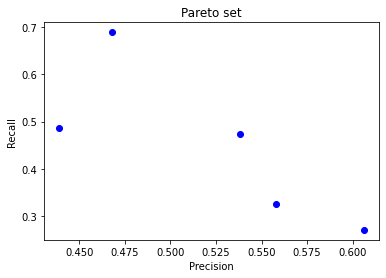

In [86]:
plot_values = []
pareto_front = automl.get_pareto_set()
for ensemble in pareto_front:
    predictions = ensemble.predict(X_test)
    precision = sklearn.metrics.precision_score(y_test, predictions)
    recall = sklearn.metrics.recall_score(y_test, predictions)
    plot_values.append((precision, recall))
fig = plt.figure()
ax = fig.add_subplot(111)
for precision, recall in plot_values:
    ax.scatter(precision, recall, c="blue")
ax.set_xlabel("Precision")
ax.set_ylabel("Recall")
ax.set_title("Pareto set")
plt.show()

In [87]:
%matplotlib inline


# Performance-over-time plot
This example shows, how to use the *performance_over_time_* attribute to plot the performance
over train time.  *performance_over_time_* can contain multiple metrics within a pandas dataframe, namely:

    - ensemble_optimization_score
    - ensemble_test_score
    - single_best_optimization_score
    - single_best_test_score
    - single_best_train_score

*auto-sklearn* can automatically encode categorical columns using a label/ordinal encoder.
This example highlights how to properly set the dtype in a DataFrame for this to happen,
and showcase how to input also testing data to autosklearn.

The X_train/y_train arguments to the fit function will be used to fit the scikit-learn model,
whereas the X_test/y_test will be used to evaluate how good this scikit-learn model generalizes
to unseen data (i.e. data not in X_train/y_train). Using test data is a good mechanism to measure
if the trained model suffers from overfit, and more details can be found on [evaluating estimator
performance](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation).

In order to provide *\*_test_score* metrics, X_test and y_test must be provided to the AutoML-Model, as 
shown in this example.

There is also support to manually indicate the feature types (whether a column is categorical
or numerical) via the argument feat_types from fit(). This is important when working with
list or numpy arrays as there is no per-column dtype (further details in the example
`sphx_glr_examples_40_advanced_example_feature_types.py`).


In [91]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

from smac.tae import StatusType

import autosklearn.classification

## Data Loading



In [92]:
# Using Australian dataset https://www.openml.org/d/40981.
# This example will use the command fetch_openml, which will
# download a properly formatted dataframe if you use as_frame=True.
# For demonstration purposes, we will download a numpy array using
# as_frame=False, and manually creating the pandas DataFrame
X, y = sklearn.datasets.fetch_openml(data_id=40981, return_X_y=True, as_frame=False)

# bool and category will be automatically encoded.
# Targets for classification are also automatically encoded
# If using fetch_openml, data is already properly encoded, below
# is an example for user reference
X = pd.DataFrame(data=X, columns=["A" + str(i) for i in range(1, 15)])
desired_boolean_columns = ["A1"]
desired_categorical_columns = ["A4", "A5", "A6", "A8", "A9", "A11", "A12"]
desired_numerical_columns = ["A2", "A3", "A7", "A10", "A13", "A14"]
for column in X.columns:
    if column in desired_boolean_columns:
        X[column] = X[column].astype("bool")
    elif column in desired_categorical_columns:
        X[column] = X[column].astype("category")
    else:
        X[column] = pd.to_numeric(X[column])

y = pd.DataFrame(y, dtype="category")

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.5, random_state=3
)
print(X.dtypes)

A1         bool
A2      float64
A3      float64
A4     category
A5     category
A6     category
A7      float64
A8     category
A9     category
A10     float64
A11    category
A12    category
A13     float64
A14     float64
dtype: object


## Build and fit a classifier



In [93]:
cls = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    per_run_time_limit=30,
)
cls.fit(X_train, y_train, X_test, y_test)

2022-10-31 00:21:38,812 - Client-EnsembleBuilder - INFO - Discarding 0/1 runs
2022-10-31 00:21:38,822 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.14912
	Members: [0]
	Weights: [1.]
	Identifiers: (1, 2, 0.0)

2022-10-31 00:21:38,848 - Client-EnsembleBuilder - INFO - DummyFuture: ([{'Timestamp': Timestamp('2022-10-31 00:21:38.828236'), 'ensemble_optimization_score': 0.8508771929824561, 'ensemble_test_score': 0.8666666666666667}], 50)/SingleThreadedClient() Started Ensemble builder job at 2022.10.31-00.21.38 for iteration 0.
2022-10-31 00:21:40,141 - Client-EnsembleBuilder - INFO - Discarding 0/1 runs
2022-10-31 00:21:40,147 - Client-EnsembleBuilder - INFO - All ensemble candidates the same, no update required
2022-10-31 00:21:40,171 - Client-EnsembleBuilder - INFO - DummyFuture: ([], 50)/SingleThreadedClient() Started Ensemble builder job at 2022.10.31-00.21.40 for iteration 1.
2022-10-31 00:21:43,013 - Client-EnsembleBuilder - INFO - Discarding 0/2 runs
2022-

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      per_run_time_limit=30, time_left_for_this_task=120)

## Get the Score of the final ensemble



In [94]:
predictions = cls.predict(X_test)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, predictions))

Accuracy score 0.8608695652173913


## Plot the ensemble performance
The *performance_over_time_* attribute returns a pandas dataframe, which can
be directly used for plotting



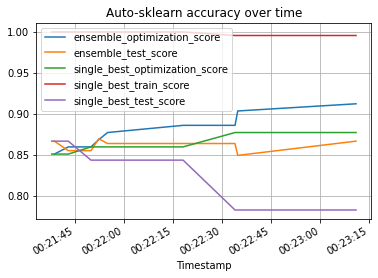

In [95]:
poT = cls.performance_over_time_
poT.plot(
    x="Timestamp",
    kind="line",
    legend=True,
    title="Auto-sklearn accuracy over time",
    grid=True,
)
plt.show()

In [96]:
%matplotlib inline


# Resampling Strategies

In *auto-sklearn* it is possible to use different resampling strategies
by specifying the arguments ``resampling_strategy`` and
``resampling_strategy_arguments``. The following example shows common
settings for the ``AutoSklearnClassifier``.


In [97]:
import numpy as np
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

import autosklearn.classification

## Data Loading



In [98]:
X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=1
)

## Holdout



In [99]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    tmp_folder="/tmp/autosklearn_resampling_example_tmp",
    disable_evaluator_output=False,
    # 'holdout' with 'train_size'=0.67 is the default argument setting
    # for AutoSklearnClassifier. It is explicitly specified in this example
    # for demonstrational purpose.
    resampling_strategy="holdout",
    resampling_strategy_arguments={"train_size": 0.67},
)
automl.fit(X_train, y_train, dataset_name="breast_cancer")

2022-10-31 00:24:11,755 - Client-EnsembleBuilder - INFO - Discarding 0/1 runs
2022-10-31 00:24:11,767 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.02837
	Members: [0]
	Weights: [1.]
	Identifiers: (1, 2, 0.0)

2022-10-31 00:24:11,794 - Client-EnsembleBuilder - INFO - DummyFuture: ([{'Timestamp': Timestamp('2022-10-31 00:24:11.771532'), 'ensemble_optimization_score': 0.9716312056737588}], 50)/SingleThreadedClient() Started Ensemble builder job at 2022.10.31-00.24.11 for iteration 0.
2022-10-31 00:24:13,299 - Client-EnsembleBuilder - INFO - Discarding 0/2 runs
2022-10-31 00:24:13,368 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.02837 1: 0.02128 2: 0.01418 3: 0.01418 4: 0.01418 5: 0.01418 6: 0.01418 7: 0.01418 8: 0.01418 9: 0.01418 10: 0.01418 11: 0.01418 12: 0.01418 13: 0.01418 14: 0.01418 15: 0.01418 16: 0.01418 17: 0.01418 18: 0.01418 19: 0.01418 20: 0.01418 21: 0.01418 22: 0.01418 23: 0.01418 24: 0.01418 25: 0.01418 26: 0.01418 27: 

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      per_run_time_limit=30,
                      resampling_strategy_arguments={'train_size': 0.67},
                      time_left_for_this_task=120,
                      tmp_folder='/tmp/autosklearn_resampling_example_tmp')

## Get the Score of the final ensemble



In [100]:
predictions = automl.predict(X_test)
print("Accuracy score holdout: ", sklearn.metrics.accuracy_score(y_test, predictions))

Accuracy score holdout:  0.9440559440559441


## Cross-validation



In [101]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    tmp_folder="/tmp/autosklearn_resampling_example_tmp",
    disable_evaluator_output=False,
    resampling_strategy="cv",
    resampling_strategy_arguments={"folds": 5},
)
automl.fit(X_train, y_train, dataset_name="breast_cancer")

# One can use models trained during cross-validation directly to predict
# for unseen data. For this, all k models trained during k-fold
# cross-validation are considered as a single soft-voting ensemble inside
# the ensemble constructed with ensemble selection.
print("Before re-fit")
predictions = automl.predict(X_test)
print("Accuracy score CV", sklearn.metrics.accuracy_score(y_test, predictions))

2022-10-31 00:26:16,107 - Client-EnsembleBuilder - INFO - Discarding 0/1 runs
2022-10-31 00:26:16,117 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.04460
	Members: [0]
	Weights: [1.]
	Identifiers: (1, 2, 0.0)

2022-10-31 00:26:16,160 - Client-EnsembleBuilder - INFO - DummyFuture: ([{'Timestamp': Timestamp('2022-10-31 00:26:16.123658'), 'ensemble_optimization_score': 0.9553990610328639}], 50)/SingleThreadedClient() Started Ensemble builder job at 2022.10.31-00.26.16 for iteration 0.
2022-10-31 00:26:22,393 - Client-EnsembleBuilder - INFO - Discarding 0/2 runs
2022-10-31 00:26:22,463 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.03052 1: 0.02582 2: 0.02113 3: 0.02347 4: 0.01878 5: 0.02113 6: 0.02113 7: 0.02347 8: 0.02113 9: 0.01878 10: 0.02113 11: 0.02113 12: 0.01878 13: 0.02113 14: 0.01878 15: 0.02113 16: 0.02113 17: 0.01878 18: 0.02113 19: 0.01878 20: 0.01878 21: 0.02113 22: 0.01878 23: 0.02113 24: 0.01878 25: 0.01878 26: 0.02113 27: 

## Perform a refit
During fit(), models are fit on individual cross-validation folds. To use
all available data, we call refit() which trains all models in the
final ensemble on the whole dataset.



In [102]:
print("After re-fit")
automl.refit(X_train.copy(), y_train.copy())
predictions = automl.predict(X_test)
print("Accuracy score CV", sklearn.metrics.accuracy_score(y_test, predictions))

After re-fit
Accuracy score CV 0.958041958041958


## scikit-learn splitter objects
It is also possible to use
[scikit-learn's splitter classes](https://scikit-learn.org/stable/modules/classes.html#splitter
-classes) to further customize the outputs. In case one needs to have 100% control over the
splitting, it is possible to use
[scikit-learn's PredefinedSplit](https://scikit-learn.org/stable/modules/generated/
sklearn.model_selection.PredefinedSplit.html).



Below is an example of using a predefined split. We split the training
data by the first feature. In practice, one would use a splitting according
to the use case at hand.



In [103]:
selected_indices = (X_train[:, 0] < np.mean(X_train[:, 0])).astype(int)
resampling_strategy = sklearn.model_selection.PredefinedSplit(
    test_fold=selected_indices
)

automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    tmp_folder="/tmp/autosklearn_resampling_example_tmp",
    disable_evaluator_output=False,
    resampling_strategy=resampling_strategy,
)
automl.fit(X_train, y_train, dataset_name="breast_cancer")

print(automl.sprint_statistics())

2022-10-31 00:28:24,711 - Client-EnsembleBuilder - INFO - Discarding 0/1 runs
2022-10-31 00:28:24,723 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.07042
	Members: [0]
	Weights: [1.]
	Identifiers: (1, 2, 0.0)

2022-10-31 00:28:24,756 - Client-EnsembleBuilder - INFO - DummyFuture: ([{'Timestamp': Timestamp('2022-10-31 00:28:24.734523'), 'ensemble_optimization_score': 0.9295774647887324}], 50)/SingleThreadedClient() Started Ensemble builder job at 2022.10.31-00.28.24 for iteration 0.
2022-10-31 00:28:27,490 - Client-EnsembleBuilder - INFO - Discarding 0/2 runs
2022-10-31 00:28:27,557 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.06573 1: 0.05164 2: 0.05399 3: 0.05164 4: 0.04460 5: 0.05164 6: 0.04460 7: 0.04695 8: 0.04695 9: 0.04460 10: 0.04930 11: 0.04460 12: 0.04460 13: 0.04460 14: 0.04460 15: 0.04460 16: 0.04460 17: 0.04460 18: 0.04460 19: 0.04460 20: 0.04460 21: 0.04460 22: 0.04460 23: 0.04460 24: 0.04460 25: 0.04460 26: 0.04460 27: 

For custom resampling strategies (i.e. resampling strategies that are not
defined as strings by Auto-sklearn) it is necessary to perform a refit:



In [104]:
automl.refit(X_train, y_train)

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      per_run_time_limit=30,
                      resampling_strategy=PredefinedSplit(test_fold=array([0, 0, ..., 1, 1])),
                      time_left_for_this_task=120,
                      tmp_folder='/tmp/autosklearn_resampling_example_tmp')

In [107]:
automl

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      per_run_time_limit=30,
                      resampling_strategy=PredefinedSplit(test_fold=array([0, 0, ..., 1, 1])),
                      time_left_for_this_task=120,
                      tmp_folder='/tmp/autosklearn_resampling_example_tmp')

## Get the Score of the final ensemble (again)

Obviously, this score is pretty bad as we "destroyed" the dataset by
splitting it on the first feature.



In [105]:
predictions = automl.predict(X_test)
print(
    "Accuracy score custom split", sklearn.metrics.accuracy_score(y_test, predictions)
)

Accuracy score custom split 0.951048951048951


In [106]:
%matplotlib inline


# Fit a single configuration

*Auto-sklearn* searches for the best combination of machine learning algorithms
and their hyper-parameter configuration for a given task, using Scikit-Learn Pipelines.
To further improve performance, this pipelines are ensemble together using Ensemble
Selection from Caruana (2004).


This example shows how one can fit one of this pipelines, both, with an user defined
configuration, and a randomly sampled one form the configuration space.

The pipelines that Auto-Sklearn fits are compatible with Scikit-Learn API. You can
get further documentation about Scikit-Learn models here: <https://scikit-learn.org/stable/getting_started.html`>_


In [108]:
import numpy as np
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

from ConfigSpace.configuration_space import Configuration

import autosklearn.classification

## Data Loading



In [109]:
X, y = sklearn.datasets.fetch_openml(data_id=3, return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.5, random_state=3
)

## Define an estimator



In [110]:
cls = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    per_run_time_limit=60,
    memory_limit=4096,
    # We will limit the configuration space only to
    # have RandomForest as a valid model. We recommend enabling all
    # possible models to get a better performance.
    include={"classifier": ["random_forest"]},
    delete_tmp_folder_after_terminate=False,
)

## Fit an user provided configuration



In [111]:
# We will create a configuration that has a user defined
# min_samples_split in the Random Forest. We recommend you to look into
# how the ConfigSpace package works here:
# https://automl.github.io/ConfigSpace/master/
cs = cls.get_configuration_space(X, y, dataset_name="kr-vs-kp")
config = cs.sample_configuration()
config._values["classifier:random_forest:min_samples_split"] = 11

# Make sure that your changed configuration complies with the configuration space
config.is_valid_configuration()

pipeline, run_info, run_value = cls.fit_pipeline(
    X=X_train,
    y=y_train,
    dataset_name="kr-vs-kp",
    config=config,
    X_test=X_test,
    y_test=y_test,
)

# This object complies with Scikit-Learn Pipeline API.
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
print(pipeline.named_steps)

# The fit_pipeline command also returns a named tuple with the pipeline constraints
print(run_info)

# The fit_pipeline command also returns a named tuple with train/test performance
print(run_value)

# We can make sure that our pipeline configuration was honored as follows
print("Passed Configuration:", pipeline.config)
print("Random Forest:", pipeline.named_steps["classifier"].choice.estimator)

# We can also search for new configurations using the fit() method
# Any configurations found by Auto-Sklearn -- even the ones created using
# fit_pipeline() are stored to disk and can be used for Ensemble Selection
cs = cls.fit(X, y, dataset_name="kr-vs-kp")

/usr/local/lib/python3.7/dist-packages/autosklearn/data/target_validator.py:188: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  "Fitting transformer with a pandas series which"


{'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f0b458a1a50>, 'balancing': Balancing(random_state=1, strategy='weighting'), 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f0b458e4490>, 'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7f0b4590b790>}
RunInfo(config=Configuration(values={
  'balancing:strategy': 'weighting',
  'classifier:__choice__': 'random_forest',
  'classifier:random_forest:bootstrap': 'True',
  'classifier:random_forest:criterion': 'gini',
  'classifier:random_forest:max_depth': 'None',
  'classifier:random_forest:max_features': 0.8086969494902054,
  'classifier:random_forest:max_leaf_nodes': 'None',
  'classifier:random_forest:min_impurity_decrease': 0.0,
  'classifier:random_forest:min_samples_leaf': 2,
  'classifier:random_forest:min_samples_split': 11,
  'classifier:random_forest:min_weight

/usr/local/lib/python3.7/dist-packages/autosklearn/data/target_validator.py:188: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  "Fitting transformer with a pandas series which"


[WARNING] [2022-10-31 00:32:48,075:Client-AutoML(1):kr-vs-kp] Capping the per_run_time_limit to 59.0 to have time for a least 2 models in each process.
[WARNING] [2022-10-31 00:32:48,877:Client-AutoMLSMBO(1)::kr-vs-kp] Configuration 230 not found
[WARNING] [2022-10-31 00:32:48,878:Client-AutoMLSMBO(1)::kr-vs-kp] Configuration 473 not found
[WARNING] [2022-10-31 00:32:48,878:Client-AutoMLSMBO(1)::kr-vs-kp] Configuration 460 not found
[WARNING] [2022-10-31 00:32:48,878:Client-AutoMLSMBO(1)::kr-vs-kp] Configuration 211 not found
[WARNING] [2022-10-31 00:32:48,878:Client-AutoMLSMBO(1)::kr-vs-kp] Configuration 138 not found
[WARNING] [2022-10-31 00:32:48,879:Client-AutoMLSMBO(1)::kr-vs-kp] Configuration 532 not found
[WARNING] [2022-10-31 00:32:48,879:Client-AutoMLSMBO(1)::kr-vs-kp] Configuration 506 not found
[WARNING] [2022-10-31 00:32:48,879:Client-AutoMLSMBO(1)::kr-vs-kp] Configuration 222 not found
[WARNING] [2022-10-31 00:32:48,879:Client-AutoMLSMBO(1)::kr-vs-kp] Configuration 454 not

In [ ]:
%matplotlib inline


# Text preprocessing

The following example shows how to fit a simple NLP problem with
*auto-sklearn*.

For an introduction to text preprocessing you can follow these links:
    1. https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    2. https://machinelearningmastery.com/clean-text-machine-learning-python/


In [112]:
from pprint import pprint

import pandas as pd
import sklearn.metrics
from sklearn.datasets import fetch_20newsgroups

import autosklearn.classification

## Data Loading



In [113]:
cats = ["comp.sys.ibm.pc.hardware", "rec.sport.baseball"]
X_train, y_train = fetch_20newsgroups(
    subset="train",  # select train set
    shuffle=True,  # shuffle the data set for unbiased validation results
    random_state=42,  # set a random seed for reproducibility
    categories=cats,  # select only 2 out of 20 labels
    return_X_y=True,  # 20NG dataset consists of 2 columns X: the text data, y: the label
)  # load this two columns separately as numpy array

X_test, y_test = fetch_20newsgroups(
    subset="test",  # select test set for unbiased evaluation
    categories=cats,  # select only 2 out of 20 labels
    return_X_y=True,  # 20NG dataset consists of 2 columns X: the text data, y: the label
)  # load this two columns separately as numpy array

## Creating a pandas dataframe
Both categorical and text features are often strings. Python Pandas stores python stings
in the generic `object` type. Please ensure that the correct
[dtype](https://pandas.pydata.org/docs/user_guide/basics.html#dtypes) is applied to the correct
column.



In [114]:
# create a pandas dataframe for training labeling the "Text" column as sting
X_train = pd.DataFrame({"Text": pd.Series(X_train, dtype="string")})

# create a pandas dataframe for testing labeling the "Text" column as sting
X_test = pd.DataFrame({"Text": pd.Series(X_test, dtype="string")})

## Build and fit a classifier



In [115]:
# create an autosklearn Classifier or Regressor depending on your task at hand.
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=60,
    per_run_time_limit=30,
)

automl.fit(X_train, y_train, dataset_name="20_Newsgroups")  # fit the automl model

[WARNING] [2022-10-31 00:34:55,440:Client-AutoML(1):20_Newsgroups] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
2022-10-31 00:35:27,538 - Client-EnsembleBuilder - INFO - Discarding 0/1 runs
2022-10-31 00:35:27,548 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.04337
	Members: [0]
	Weights: [1.]
	Identifiers: (1, 2, 0.0)

2022-10-31 00:35:27,582 - Client-EnsembleBuilder - INFO - DummyFuture: ([{'Timestamp': Timestamp('2022-10-31 00:35:27.555412'), 'ensemble_optimization_score': 0.9566326530612245}], 50)/SingleThreadedClient() Started Ensemble builder job at 2022.10.31-00.35.27 for iteration 0.
2022-10-31 00:35:44,743 - Client-EnsembleBuilder - INFO - Discarding 0/1 runs
2022-10-31 00:35:44,749 - Client-EnsembleBuilder - INFO - All ensemble candidates the same, no update required
2022-10-31 00:35:44,784 - Client-EnsembleBuilder - INFO - DummyFuture: ([], 50)/SingleThreadedClient() Started Ensemble builder job at 2022.1

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      per_run_time_limit=30, time_left_for_this_task=60)

## View the models found by auto-sklearn



In [116]:
print(automl.leaderboard())

          rank  ensemble_weight           type      cost   duration
model_id                                                           
2            1              1.0  random_forest  0.043367  17.100759


## Print the final ensemble constructed by auto-sklearn



In [117]:
pprint(automl.show_models(), indent=4)

{   2: {   'balancing': Balancing(random_state=1),
           'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7f0b462fb890>,
           'cost': 0.04336734693877553,
           'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f0b43b9ae90>,
           'ensemble_weight': 1.0,
           'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f0b462fb790>,
           'model_id': 2,
           'rank': 1,
           'sklearn_classifier': RandomForestClassifier(max_features=10, n_estimators=512, n_jobs=1,
                       random_state=1, warm_start=True)}}


## Get the Score of the final ensemble



In [118]:
predictions = automl.predict(X_test)
print("Accuracy score:", sklearn.metrics.accuracy_score(y_test, predictions))

Accuracy score: 0.9759188846641318


In [119]:
print("Classification Report:", sklearn.metrics.classification_report(y_test, predictions))

Classification Report:               precision    recall  f1-score   support

           0       0.97      0.99      0.98       392
           1       0.99      0.96      0.98       397

    accuracy                           0.98       789
   macro avg       0.98      0.98      0.98       789
weighted avg       0.98      0.98      0.98       789

